# <font color="blue">Imports</font>

In [59]:
# Import des librairies
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, fcluster, centroid
from sklearn.cluster import KMeans
from Data.functions import *

In [60]:
# Import des fichiers
dispo_alim = pd.read_csv("Data/DisponibiliteAlimentaire_2017.csv", sep=";")
pop = pd.read_csv("Data/Population_2000_2018.csv",sep=";")
douane = pd.read_csv("Data/taux_douane.csv", sep=";")
inflation = pd.read_csv("Data/Inflation.csv", sep=";")
pib_hab = pd.read_csv("Data/pib_hab.csv", sep=";")
vegetarian = pd.read_csv("Data/vegetarian.csv", sep=";")
urba = pd.read_csv("Data/urba.csv", sep=";")
pol_stab = pd.read_csv("Data/political stability.csv", sep=";")
tourisme = pd.read_csv("Data/tourisme.csv", sep=";")
pop_2017 = pop[pop.Année == 2017]
pop_2017 = pop_2017[["Zone", "Valeur"]]
pop_2017.columns = ["Zone", "Population"]

# <font color="blue">Traitements</font>

In [61]:
# Dispo alimentaire de poulet 
dispo_poulet = (dispo_alim.Produit == 'Viande de Volailles') & (dispo_alim.Élément == 'Disponibilité alimentaire en quantité (kg/personne/an)')
dispo_poulet = dispo_alim[dispo_poulet].groupby(["Zone"]).agg({"Valeur" : "sum"}).reset_index()
dispo_poulet.columns = ["Zone", "Dispo_poulet(Kg/hab)"]

In [62]:
# Import poulet 
import_poulet = (dispo_alim.Produit == 'Viande de Volailles') & (dispo_alim.Élément == 'Importations - Quantité')
import_poulet = dispo_alim[import_poulet].groupby(["Zone"]).agg({"Valeur" : "sum"}).reset_index()
import_poulet.columns = ["Zone", "Import_poulet(MT)"]

In [63]:
# Export poulet 
export_poulet = (dispo_alim.Produit == 'Viande de Volailles') & (dispo_alim.Élément == 'Exportations - Quantité')
export_poulet = dispo_alim[export_poulet].groupby(["Zone"]).agg({"Valeur" : "sum"}).reset_index()
export_poulet.columns = ["Zone", "Export_poulet(MT)"]

In [64]:
# Fusion
df = pop_2017.merge(dispo_poulet, how='inner')
df = df.merge(import_poulet, how='left')
df = df.merge(export_poulet, how='left')

In [65]:
# Solde d'import/export
solde_import_export = df[["Population","Import_poulet(MT)", "Export_poulet(MT)"]].apply(lambda x : round(((x[1]-x[2])*1000)/x[0],2), axis=1)
df.insert(loc=5,column="Solde_import_export_poulet(T/hab)",value=solde_import_export)
df = df[["Zone", "Population", "Dispo_poulet(Kg/hab)", "Solde_import_export_poulet(T/hab)"]]

In [66]:
# Droits de douane
douane.astype({'Taux douane': 'float64'})
df = df.merge(douane, how='left')

In [67]:
# Inflation
df = df.merge(inflation, how='left')

In [68]:
# Pib/hab
df = df.merge(pib_hab, how='left')

In [69]:
# Vegetarian
df = df.merge(vegetarian, how='left')

In [70]:
# Urba
df = df.merge(urba, how='left')

In [71]:
# Political stab
df = df.merge(pol_stab, how='left')

In [72]:
# tourisme
df = df.merge(tourisme, how='left')

In [73]:
# suppression des pays avec trop de valeurs manquantes
def nb_miss(data):
    cpt = 0
    for col in range(len(data)) :
        if pd.isna(data[col]) :
            cpt +=1
    return cpt 
nb_miss = df.apply(nb_miss, axis=1)
df.insert(loc=5,column="nb_miss",value=nb_miss)
df = df[df["nb_miss"] < 4]
del df["nb_miss"]

In [74]:
# remplacement des valeurs manquantes par la moyenne
df = df.fillna(value={"Vegetarian": np.mean(df["Vegetarian"])})
df = df.fillna(value={"Taux douane": np.mean(df["Taux douane"])})
df = df.fillna(value={"Inflation": np.mean(df["Inflation"])})
df = df.fillna(value={"Pib_hab": np.mean(df["Pib_hab"])})
df = df.fillna(value={"Taux urbanisation": np.mean(df["Taux urbanisation"])})
df = df.fillna(value={"Pol_stab": np.mean(df["Pol_stab"])})
df = df.fillna(value={"Tourisme": np.mean(df["Tourisme"])})
df = df.fillna(value={"Solde_import_export_poulet(T/hab)": np.mean(df["Solde_import_export_poulet(T/hab)"])})

# <font color="blue">ACP</font>

In [75]:
# On supprime l'Inde et la Chine car contribue trop aux axes de l'ACP
df_acp = df[~df.Zone.isin(["France", "Chine", "Inde"])]
df_acp = df_acp.set_index("Zone",inplace=False,drop=True)
df_excl = df[df.Zone.isin(["Inde", "Chine"])].set_index("Zone",inplace=False,drop=True)

In [76]:
#df_pays = df_pays[["Population", "Dispo_poulet(KCAL/hab/jour)", "Pib_hab", "Vegetarian", "Pol_stab", "Taux douane", "Taux urbanisation", "Solde_import_export_poulet(T/hab)", "Inflation"]]

In [77]:
# Paramètres ACP
X = df_acp.values
names = df_acp.index
features = df_acp.columns
n_comp = 3

In [78]:
# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [79]:
# Mise en place de l'ACP
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=3)

[0.29385676 0.17492547 0.1278219 ]
0.5966041255350598


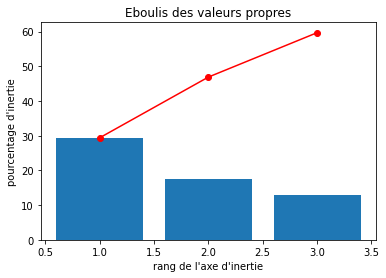

In [80]:
# Part d'inertie expliquée 
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# Eboulis des valeurs propres
display_scree_plot(pca)

In [81]:
pcs = pca.components_

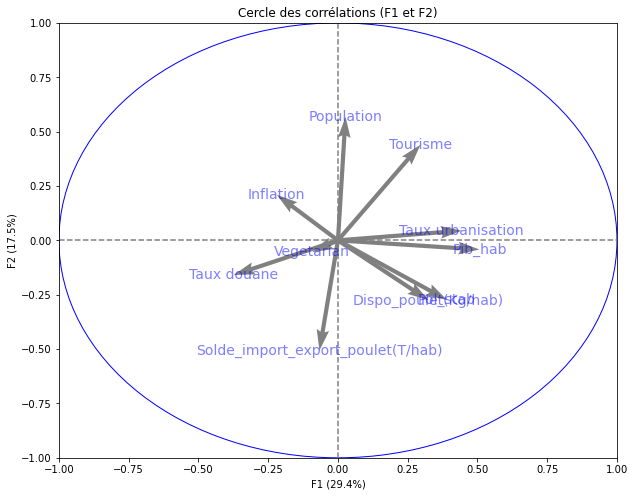

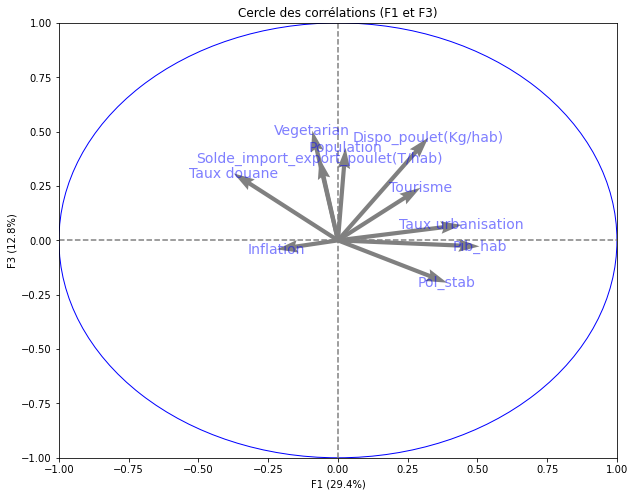

In [82]:
#Analyse du cercle des corrélations 
display_circles(pcs, n_comp, pca, [(0,1),(0,2)], labels = np.array(features))

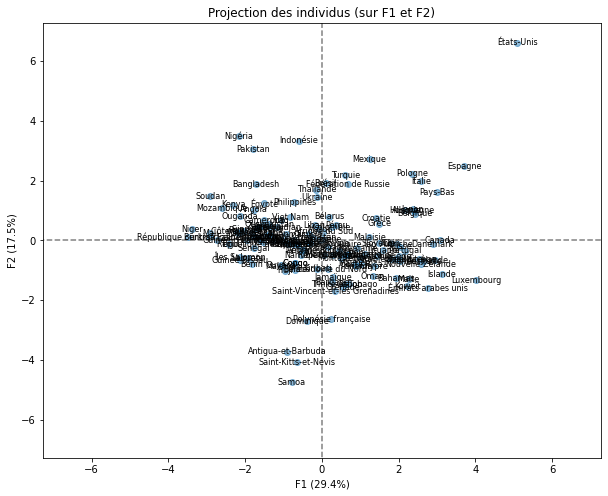

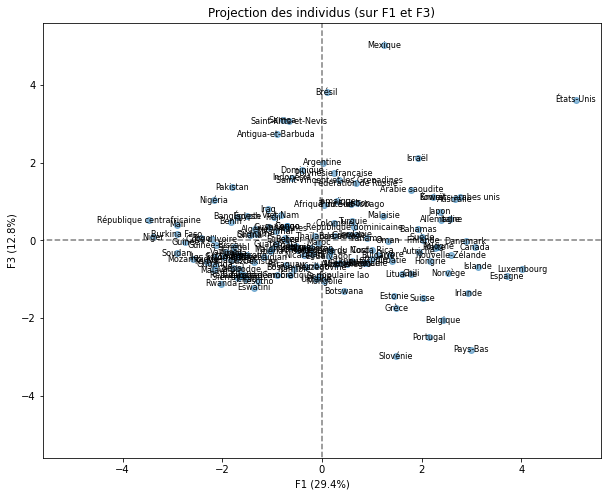

In [83]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(0,2)], labels = names, illustrative_var = None, alpha = 0.5)

In [84]:
# On observe les contributions des individus aux axes
contrib = X_projected ** 2
rows = df_acp.shape[0]
for i in range(n_comp):
    contrib[:,i] = contrib[:,i] / (rows * pca.explained_variance_[i])

contr = pd.DataFrame(data=contrib, columns=["F1", "F2", "F3"], index=df_acp.index)    
contr.sort_values("F1", ascending = False)
contr.sort_values("F2", ascending = False)

,F1,F2,F3
Zone,,,
États-Unis,0.060803,1.721537e-01,0.070939
Samoa,0.001469,8.808255e-02,0.051926
Saint-Kitts-et-Nevis,0.001020,6.517527e-02,0.050817
Antigua-et-Barbuda,0.001950,5.461481e-02,0.040377
Nigéria,0.010988,4.825791e-02,0.005711
...,...,...,...
Guinée,0.017642,1.014110e-06,0.000008
Tadjikistan,0.006207,4.057016e-07,0.004356
Canada,0.022038,6.908036e-08,0.000169


# <font color="blue">CAH</font>

In [85]:
df_cluster = df_acp

In [86]:
# On applique clustering sur résultat de l'ACP 
#X = df_cluster.values
X = X_projected
names = df_cluster.index

In [87]:
# Centrage et réduction
#std_scale = preprocessing.StandardScaler().fit(X)
#X_scaled = std_scale.transform(X)

In [88]:
# Clustering hierarchique
#Z = linkage(X_scaled, 'ward')
Z = linkage(X_projected, 'ward')

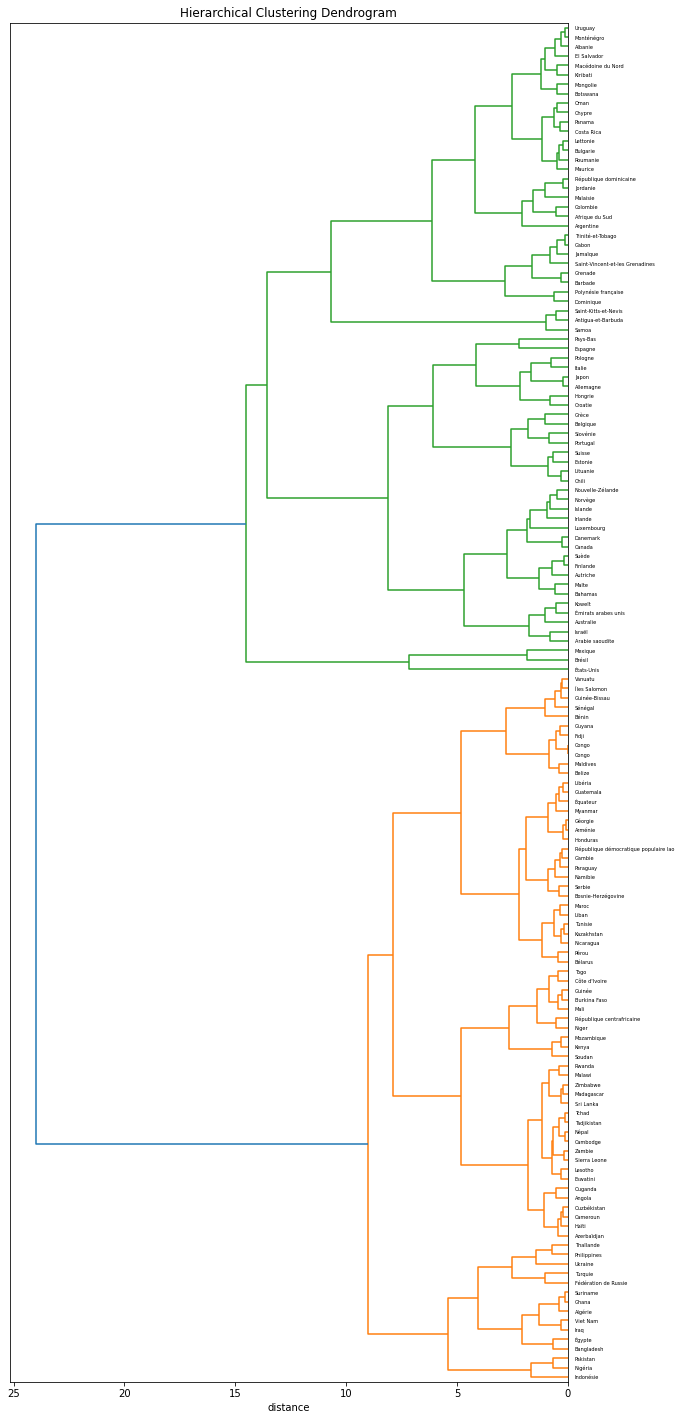

In [89]:
# Dendogramme
plot_dendrogram(Z, names)

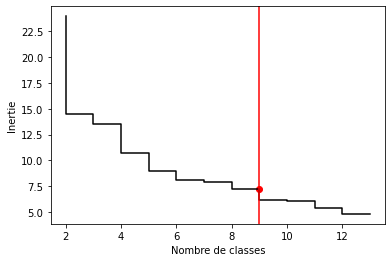

In [90]:
# Diagramme d'inertie
last = Z[-12:, 2]
last_rev = last[::-1]
idxs = np.arange(2, len(last) + 2)
plt.step(idxs, last_rev, c="black")
plt.xlabel("Nombre de classes")
plt.ylabel("Inertie")
nombre = 9 # on teste nb de classe
plt.scatter(idxs[np.where(idxs==nombre)], last_rev[np.where(idxs==nombre)], c="red")
plt.axvline(idxs[np.where(idxs==nombre)], c="red")
plt.show()

In [91]:
# Coupage du dendrogramme en 9 clusters
clusters = fcluster(Z, 9, criterion='maxclust')

In [92]:
df_cluster.insert(loc=0,column="Cluster",value=clusters)

In [93]:
# Cluster Map
#df_pays_cluster = df_cluster.iloc[:,1:8].sub(df_cluster.iloc[:,1:8].mean()) 
#df_pays_cluster = df_pays_cluster.div(df_pays_cluster.std()) 
#cluster_colors = df_cluster["Cluster"].map({ 1 : "blue", 2 : "green", 3: "yellow", 4 : "orange", 5 : "red"})
#sns.clustermap(df_pays_cluster,method='ward',metric='euclidean', row_colors=cluster_colors) 

In [94]:
# Valeurs moyennes par cluster (données avant ACP)
mean_cluster=df_cluster.pivot_table(index="Cluster",values=df_cluster.columns,aggfunc=np.mean)
mean_cluster

,Dispo_poulet(Kg/hab),Inflation,Pib_hab,Pol_stab,Population,Solde_import_export_poulet(T/hab),Taux douane,Taux urbanisation,Tourisme,Vegetarian
Cluster,,,,,,,,,,
1,13.436000,116.619622,12213.866667,-0.950609,104553.999067,2.250311,6.285695,55.466667,1.377756e+07,0.086558
2,4.140690,119.615825,3890.344828,-0.758127,19372.819138,3.814324,7.620933,34.655172,1.177931e+06,0.088182
3,16.415806,107.642319,9287.580645,-0.290478,9679.655645,4.641399,7.047198,53.451613,3.115896e+06,0.088182
4,40.275000,112.942600,17123.000000,-0.355000,166305.573500,-6.290000,8.190000,83.000000,5.296900e+07,0.165000
5,55.680000,109.350287,59915.000000,-0.020000,325084.756000,-10.980000,3.360000,82.000000,1.742918e+08,0.050000
6,33.409412,102.919423,55549.705882,0.758286,9568.889176,8.530863,2.902308,84.764706,1.145882e+07,0.096428
7,22.400000,103.975336,39195.875000,0.600000,28238.414750,-5.929375,2.610625,74.500000,3.638606e+07,0.062409
8,58.213333,100.291184,17768.666667,0.320577,114.274333,79.080000,12.466667,24.666667,7.973333e+05,0.088182
9,30.262333,105.106812,18780.394977,0.293144,9140.346933,11.216290,5.267105,66.866667,4.821679e+06,0.089636


In [95]:
# Liste des pays par cluster
list_clus = {}
for k in np.unique(np.array(clusters)):
    elt = 40 -len(df_cluster[df_cluster.Cluster==k].index.tolist())
    list = df_cluster[df_cluster.Cluster==k].index.tolist()
    if elt > 0 :
        for j in range(elt):
            list.append("NaN")
    list_clus[k] = list
pd.DataFrame(list_clus)

,1,2,3,4,5,6,7,8,9
0,Algérie,Angola,Arménie,Brésil,États-Unis,Arabie saoudite,Allemagne,Antigua-et-Barbuda,Afrique du Sud
1,Bangladesh,Azerbaïdjan,Bélarus,Mexique,NaN,Australie,Belgique,Saint-Kitts-et-Nevis,Albanie
2,Égypte,Burkina Faso,Belize,NaN,NaN,Autriche,Chili,Samoa,Argentine
3,Fédération de Russie,Cambodge,Bénin,NaN,NaN,Bahamas,Croatie,NaN,Barbade
4,Ghana,Cameroun,Bosnie-Herzégovine,NaN,NaN,Canada,Espagne,NaN,Botswana
5,Indonésie,Côte d'Ivoire,Congo,NaN,NaN,Danemark,Estonie,NaN,Bulgarie
6,Iraq,Eswatini,Congo,NaN,NaN,Émirats arabes unis,Grèce,NaN,Chypre
7,Nigéria,Guinée,Équateur,NaN,NaN,Finlande,Hongrie,NaN,Colombie
8,Pakistan,Haïti,Fidji,NaN,NaN,Irlande,Italie,NaN,Costa Rica
9,Philippines,Kenya,Gambie,NaN,NaN,Islande,Japon,NaN,Dominique


176

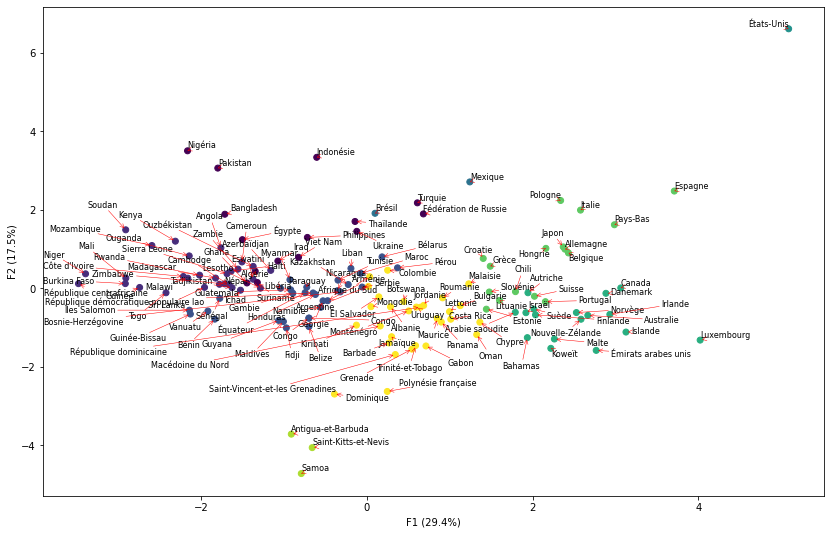

In [96]:
# Affichage des pays sur les axes de l'ACP
from adjustText import adjust_text
fig = plt.figure(figsize=(14,9))
plt.scatter(X_projected[:,0], X_projected[:,1], c=clusters)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
texts = []
for i, (x, y) in enumerate(zip(X_projected[:, 0], X_projected[:, 1])):
    texts.append(plt.text(x, y, df_acp.index[i], size = 8))
    
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

# <font color="blue">K-MEANS</font>

In [39]:
# Mise en place du KMEANS
km = KMeans(n_clusters= 9)
#km.fit(X_scaled)
km.fit(X_projected)
clusters_kmeans = km.labels_
centroids_after_kmeans = km.cluster_centers_

Text(0.5, 1.0, 'The Elbow Method using Inertia')

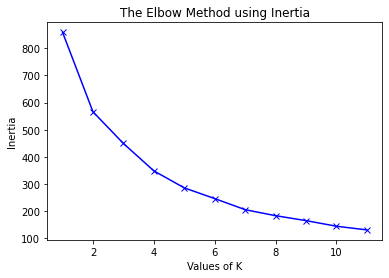

In [54]:
# Diagramme d'inertie
inertias = [] 
mapping = {} 
K = range(1,12) 
  
for k in K: 
    
    #kmeanModel = KMeans(n_clusters=k).fit(X_scaled) 
    kmeanModel = KMeans(n_clusters=k).fit(X_projected) 
    #kmeanModel.fit(X_scaled)     
    kmeanModel.fit(X_projected) 
    
    inertias.append(kmeanModel.inertia_) 
  
    mapping[k] = kmeanModel.inertia_ 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 

176

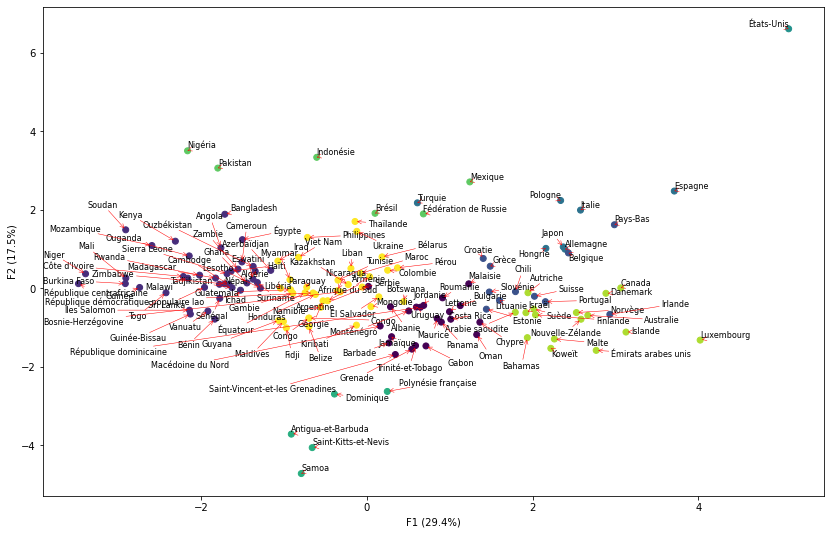

In [41]:
# Affichage des pays sur les axes de l'ACP
from adjustText import adjust_text
fig = plt.figure(figsize=(14,9))
plt.scatter(X_projected[:,0], X_projected[:,1], c=clusters_kmeans)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
texts = []
for i, (x, y) in enumerate(zip(X_projected[:, 0], X_projected[:, 1])):
    texts.append(plt.text(x, y, df_acp.index[i], size = 8))
    
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

In [42]:
# Liste des pays par cluster
df_cluster.insert(loc=0,column="Cluster_KMEANS",value=clusters_kmeans)
list_clus = {}
for k in np.unique(np.array(clusters_kmeans)):
    elt = 40 -len(df_cluster[df_cluster.Cluster_KMEANS==k].index.tolist())
    list = df_cluster[df_cluster.Cluster_KMEANS==k].index.tolist()
    if elt > 0 :
        for j in range(elt):
            list.append("NaN")
    list_clus[k] = list
pd.DataFrame(list_clus)

,0,1,2,3,4,5,6,7,8
0,Albanie,Algérie,Belgique,Allemagne,États-Unis,Antigua-et-Barbuda,Brésil,Arabie saoudite,Afrique du Sud
1,Argentine,Angola,Chili,Espagne,NaN,Dominique,Fédération de Russie,Australie,Arménie
2,Barbade,Azerbaïdjan,Croatie,Hongrie,NaN,Polynésie française,Indonésie,Autriche,Bélarus
3,Bulgarie,Bangladesh,Estonie,Italie,NaN,Saint-Kitts-et-Nevis,Mexique,Bahamas,Belize
4,Chypre,Bénin,Grèce,Japon,NaN,Samoa,Nigéria,Canada,Bosnie-Herzégovine
5,Costa Rica,Burkina Faso,Irlande,Pologne,NaN,NaN,Pakistan,Danemark,Botswana
6,Gabon,Cambodge,Lituanie,Turquie,NaN,NaN,NaN,Émirats arabes unis,Colombie
7,Grenade,Cameroun,Pays-Bas,NaN,NaN,NaN,NaN,Finlande,Congo
8,Jamaïque,Côte d'Ivoire,Portugal,NaN,NaN,NaN,NaN,Islande,Congo
9,Jordanie,Égypte,Slovénie,NaN,NaN,NaN,NaN,Israël,El Salvador


In [43]:
# Valeurs moyennes par cluster (données avant ACP)
mean_cluster_kmean = df_cluster.pivot_table(index="Cluster_KMEANS",values=df_cluster.columns,aggfunc=np.mean)
mean_cluster_kmean

,Cluster,Dispo_poulet(Kg/hab),Inflation,Pib_hab,Pol_stab,Population,Solde_import_export_poulet(T/hab),Taux douane,Taux urbanisation,Tourisme,Vegetarian
Cluster_KMEANS,,,,,,,,,,,
0,9.000000,32.410455,104.595689,21193.727273,0.326482,7096.459227,9.139970,5.056996,66.681818,5.480130e+06,0.090165
1,2.000000,5.555128,118.841881,4563.128205,-0.659031,23547.824795,4.573062,8.382193,37.487179,1.478532e+06,0.088182
2,6.909091,21.946364,103.832514,42699.272727,0.600000,8309.331727,-5.594545,2.560000,73.181818,1.599618e+07,0.054397
3,6.142857,23.350000,105.227814,37586.428571,0.398571,63754.530857,-5.331429,2.690000,75.000000,6.493243e+07,0.079052
4,5.000000,55.680000,109.350287,59915.000000,-0.020000,325084.756000,-10.980000,3.360000,82.000000,1.742918e+08,0.050000
5,8.400000,51.446000,101.128746,16917.569863,0.152693,138.076600,69.510000,10.886000,41.200000,5.752000e+05,0.088182
6,2.000000,20.931667,115.133191,13564.833333,-0.941667,190261.940833,-1.971667,6.499746,63.500000,2.840996e+07,0.113788
7,6.000000,33.883750,103.327863,54162.250000,0.744429,9869.864812,8.985292,2.928702,86.125000,1.152888e+07,0.098392
8,3.702703,17.849459,107.672548,10724.108108,-0.313714,19986.208000,3.770361,5.708672,58.081081,5.428790e+06,0.087523


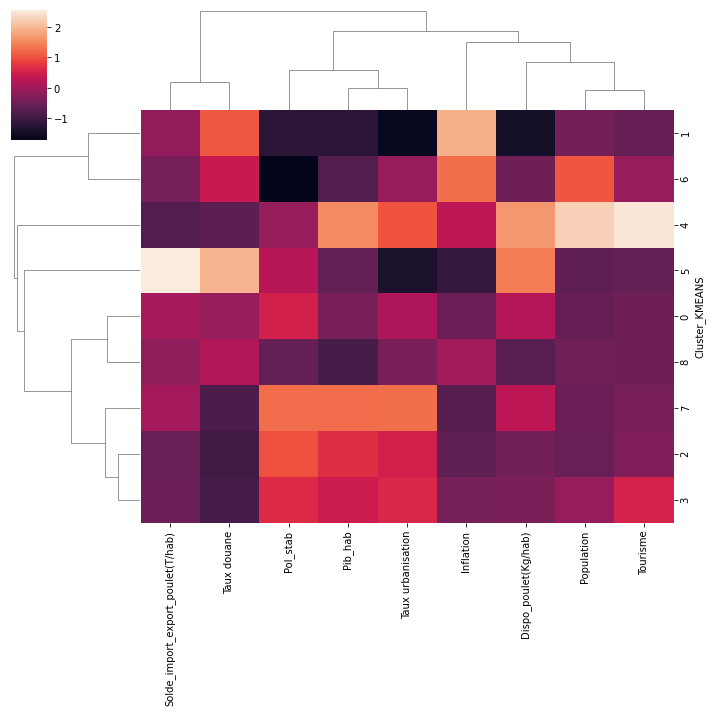

In [44]:
# Cluster Map
mean_cluster = mean_cluster_kmean.iloc[:,1:10].sub(mean_cluster_kmean.iloc[:,1:10].mean()) 
mean_cluster = mean_cluster.div(mean_cluster.std()) 
sns.clustermap(mean_cluster,method='ward',metric='euclidean') 

# <font color="blue">DBSCAN</font>

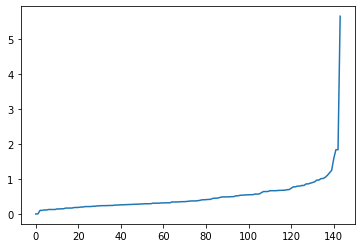

In [45]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
#nbrs = neigh.fit(X_scaled)
nbrs = neigh.fit(X_projected)
#distances, indices = nbrs.kneighbors(X_scaled)
distances, indices = nbrs.kneighbors(X_projected)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

176

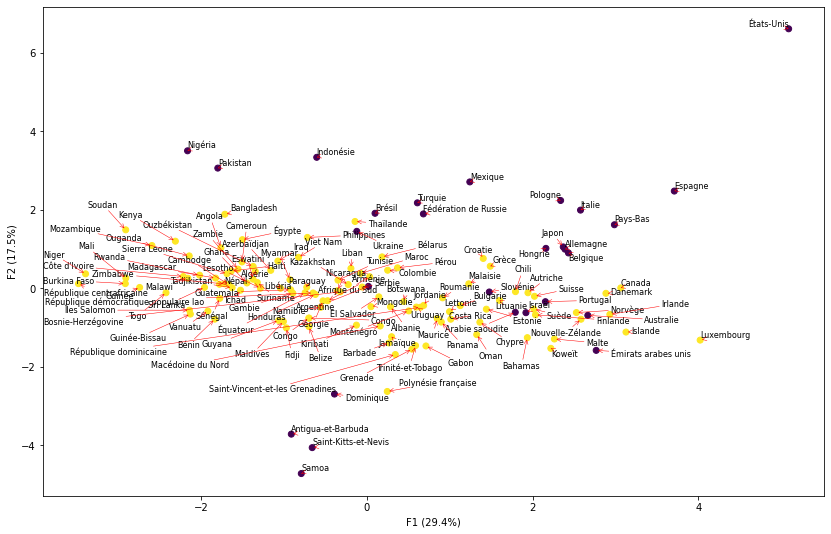

In [46]:
from sklearn.cluster import DBSCAN
fig = plt.figure(figsize=(14,9))
#y_pred = DBSCAN(eps = 2, min_samples=5).fit_predict(X_scaled)
y_pred = DBSCAN(eps = 1, min_samples=5).fit_predict(X_projected)
plt.scatter(X_projected[:,0], X_projected[:,1],c = y_pred)
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
texts = []
for i, (x, y) in enumerate(zip(X_projected[:, 0], X_projected[:, 1])):
    texts.append(plt.text(x, y, df_cluster.index[i], size = 8))
    
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

# Choix du pays

In [50]:
# On conserve le cluster kmeans qui nous intéresse 
df_fin = df_cluster[df_acp.Cluster_KMEANS.isin([3,4])]
df_fin

,Cluster_KMEANS,Cluster,Population,Dispo_poulet(Kg/hab),Solde_import_export_poulet(T/hab),Taux douane,Inflation,Pib_hab,Vegetarian,Taux urbanisation,Pol_stab,Tourisme
Zone,,,,,,,,,,,,
Allemagne,3,7,82658.409,19.47,2.37,2.48,102.700000,53071.0,0.100000,77.0,0.67,37452000.0
Espagne,3,7,46647.428,30.39,-0.15,2.48,102.386200,39529.0,0.014000,80.0,0.40,121717000.0
États-Unis,4,5,325084.756,55.68,-10.98,3.36,109.350287,59915.0,0.050000,82.0,-0.02,174291750.0
Hongrie,3,7,9729.823,25.27,-15.62,2.48,103.821400,29501.0,0.088182,71.0,0.86,54962000.0
Italie,3,7,60673.701,18.88,-1.42,2.48,101.500000,41581.0,0.089000,70.0,0.44,89931000.0
Japon,3,7,127502.725,18.50,8.31,3.69,102.020100,41444.0,0.090000,92.0,1.04,28691000.0
Pologne,3,7,37953.180,30.30,-25.56,2.48,105.404400,30065.0,0.084000,60.0,0.57,83804000.0
Turquie,3,1,81116.450,20.64,-5.25,2.74,118.762600,27914.0,0.088182,75.0,-1.19,37970000.0


In [51]:
# On trie selon la dispo la plus faible
df_fin = df_fin.drop(columns=["Cluster_KMEANS", "Cluster"])
df_fin.sort_values("Dispo_poulet(Kg/hab)", ascending = True)

,Population,Dispo_poulet(Kg/hab),Solde_import_export_poulet(T/hab),Taux douane,Inflation,Pib_hab,Vegetarian,Taux urbanisation,Pol_stab,Tourisme
Zone,,,,,,,,,,
Japon,127502.725,18.50,8.31,3.69,102.020100,41444.0,0.090000,92.0,1.04,28691000.0
Italie,60673.701,18.88,-1.42,2.48,101.500000,41581.0,0.089000,70.0,0.44,89931000.0
Allemagne,82658.409,19.47,2.37,2.48,102.700000,53071.0,0.100000,77.0,0.67,37452000.0
Turquie,81116.450,20.64,-5.25,2.74,118.762600,27914.0,0.088182,75.0,-1.19,37970000.0
Hongrie,9729.823,25.27,-15.62,2.48,103.821400,29501.0,0.088182,71.0,0.86,54962000.0
Pologne,37953.180,30.30,-25.56,2.48,105.404400,30065.0,0.084000,60.0,0.57,83804000.0
Espagne,46647.428,30.39,-0.15,2.48,102.386200,39529.0,0.014000,80.0,0.40,121717000.0
États-Unis,325084.756,55.68,-10.98,3.36,109.350287,59915.0,0.050000,82.0,-0.02,174291750.0


In [52]:
#Comparaison du pays retenu avec la moyenne du cluster et les pays exclus de l'ACP (Inde et Chine)
mean_cluster = df_fin.apply(np.mean, axis=0)
mean_cluster = pd.DataFrame(mean_cluster, columns=["Moyenne Cluster"])
japon = df_fin.loc["Japon"]
japon = pd.DataFrame(japon, columns=["Japon"])
japon.insert(loc=1,column="Moyenne Cluster",value=mean_cluster["Moyenne Cluster"])
japon = japon.transpose()
japon = pd.concat([japon,df_excl])
japon

,Population,Dispo_poulet(Kg/hab),Solde_import_export_poulet(T/hab),Taux douane,Inflation,Pib_hab,Vegetarian,Taux urbanisation,Pol_stab,Tourisme
Japon,127502.725,18.50000,8.3100,3.69000,102.020100,41444.0,0.09000,92.000,1.04000,2.869100e+07
Moyenne Cluster,96420.809,27.39125,-6.0375,2.77375,105.743123,40377.5,0.07542,75.875,0.34625,7.860234e+07
Chine,1421021.791,12.33000,-0.0900,8.46000,109.350287,14244.0,0.05000,58.000,-0.29000,1.532600e+08
Inde,1338676.785,2.22000,-0.0000,8.88000,105.957767,6183.0,0.30000,34.000,-0.86000,1.554300e+07


[Text(0.5, 1.0, 'Tourisme')]

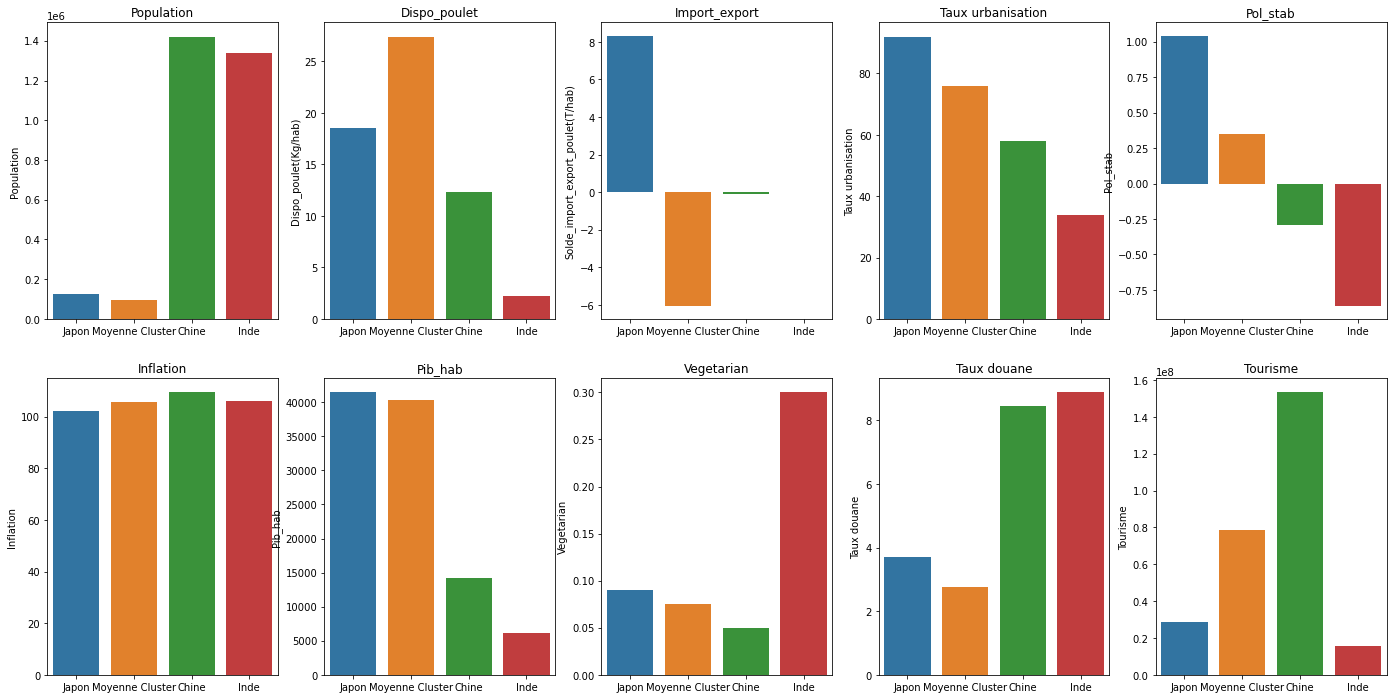

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24,12))
sns.barplot(ax=axes[0,0], data=japon, y="Population", x=japon.index).set(title='Population')
sns.barplot(ax=axes[0,1], data=japon, y="Dispo_poulet(Kg/hab)", x=japon.index).set(title='Dispo_poulet')
sns.barplot(ax=axes[0,2], data=japon, y="Solde_import_export_poulet(T/hab)", x=japon.index).set(title='Import_export')
sns.barplot(ax=axes[0,3], data=japon, y="Taux urbanisation", x=japon.index).set(title='Taux urbanisation')
sns.barplot(ax=axes[0,4], data=japon, y="Pol_stab", x=japon.index).set(title='Pol_stab')
sns.barplot(ax=axes[1,0], data=japon, y="Taux douane", x=japon.index).set(title='Taux douane')
sns.barplot(ax=axes[1,0], data=japon, y="Inflation", x=japon.index).set(title='Inflation')
sns.barplot(ax=axes[1,1], data=japon, y="Pib_hab", x=japon.index).set(title='Pib_hab')
sns.barplot(ax=axes[1,2], data=japon, y="Vegetarian", x=japon.index).set(title='Vegetarian')
sns.barplot(ax=axes[1,3], data=japon, y="Taux douane", x=japon.index).set(title='Taux douane')
sns.barplot(ax=axes[1,4], data=japon, y="Tourisme", x=japon.index).set(title='Tourisme')